## Notebook used for selecting cases in the PERSON study and fitting EDES

In [1]:
using DataFrames # for data manipulation
using MAT  # for reading .mat files

In [63]:
# load in data
file_path = "C:/Users/20192809/Documents/Data/Person_OGTT.mat"
data = matread(file_path)["OGTT_1"]

glucose = data["glucose"]
insulin = data["insulin"]
time_G = data["time_G"][:]
time_I = data["time_I"][:]
bodyweight = data["BW"][:]
G_dose = 75000
IDs = collect(1:size(glucose, 1))

using DataFrames

# Check for NaN and missing values in each variable
function check_nan_missing(data, name)
    nan_count = sum(isnan.(data))
    missing_count = sum(ismissing.(data))
    println("$name:")
    println("  NaN values: ", nan_count)
    println("  Missing values: ", missing_count)
end

# Apply the function to each variable
check_nan_missing(glucose, "Glucose")
check_nan_missing(insulin, "Insulin")
check_nan_missing(time_G, "Time_G")
check_nan_missing(time_I, "Time_I")
check_nan_missing(bodyweight, "Bodyweight")





243×1 Matrix{Float64}:
  84.95
 113.3
  88.4
  65.9
  77.7
 101.2
  88.0
  86.2
 100.2
  70.8
   ⋮
  88.9
 103.3
  76.45
  82.8
  83.32
  97.7
  89.0
 NaN
 NaN

In [105]:

# Function to find rows with NaN or missing values
function find_bad_rows(matrix1, matrix2, vector1, vector2)
    bad_rows = Set{Int}()  # Use a Set to store unique row indices

    # Check for NaN or missing in the matrix (glucose or insulin)
    for i in 1:size(matrix1, 1)
        if any(isnan.(matrix1[i, :])) || any(ismissing.(matrix1[i, :]))
            push!(bad_rows, i)
        end
    end

    for i in 1:size(matrix2, 1)
        if any(isnan.(matrix2[i, :])) || any(ismissing.(matrix2[i, :]))
            push!(bad_rows, i)
        end
    end

    # Check for NaN or missing in the vectors (IDs or bodyweight)
    for i in 1:length(vector1)
        if isnan(vector1[i]) || ismissing(vector1[i])
            push!(bad_rows, i)
        end
    end

    for i in 1:length(vector2)
        if isnan(vector2[i]) || ismissing(vector2[i])
            push!(bad_rows, i)
        end
    end

    return sort(collect(bad_rows))  # Convert Set to sorted Vector
end

# Find rows to drop
bad_rows = find_bad_rows(glucose, insulin,  IDs, bodyweight)

# Drop the bad rows from all variables
glucose_cleaned = glucose[setdiff(1:size(glucose, 1), bad_rows), :]
insulin_cleaned = insulin[setdiff(1:size(insulin, 1), bad_rows), :]
IDs_cleaned = IDs[setdiff(1:length(IDs), bad_rows)]
bodyweight_cleaned = bodyweight[setdiff(1:length(bodyweight), bad_rows)]

# Display the cleaned data
println("Cleaned Glucose: ", size(glucose_cleaned))
println("Cleaned Insulin: ", size(insulin_cleaned))
println("Cleaned IDs: ", length(IDs_cleaned))
println("Cleaned Bodyweight: ", length(bodyweight_cleaned))

Cleaned Glucose: (236, 7)
Cleaned Insulin: (236, 7)
Cleaned IDs: 236
Cleaned Bodyweight: 236


In [106]:
# fitting hyperparameters
parameters_to_fit = ["k1","k5", "k6"]#, "k8"]
ub = [0.5, 1.5, 10.]#, 20.]#0.5
lb =  [0.0005, 0, 0.5]#, 0.]# 0.0005
save_file = false

false

In [107]:
using Distributed

n_cores = length(Sys.cpu_info())

if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Random # for solving ODEs
    using DataFrames
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("../EDES/including.jl")
end


# extract data from the OGTT data
time_G = data["time_G"][:]
time_I = data["time_I"][:]
G_dose = 75000



# Prepare the patients list with positional and keyword arguments as a tuple
patients = [
    (glucose_cleaned[i, :], insulin_cleaned[i, :], bodyweight_cleaned[i], G_dose, time_G, time_I, 
    (parameters_to_fit, ub, lb, save_file)) 
    for i in 1:size(glucose_cleaned, 1)
]

# Wrapper function to pass keyword arguments correctly
@everywhere function wrapper(params)
    glucose, insulin, BW, meal_G, time_G, time_I, (estimated_params, ub, lb, save_boolean) = params
    ParameterEstimation(
        glucose,
        insulin,
        BW,
        meal_G,
        time_G,
        time_I;
        estimated_params = estimated_params,
        ub = ub,
        lb = lb,
        save_boolean = save_boolean
    )
end

# Use pmap with the wrapper
results = pmap(x -> wrapper(x), patients)

# close the parallel pool

rmprocs(procs()[2:end])


      From worker 26:	Optimization successful! continuing...
      From worker 26:	Parameter estimation done!
      From worker 24:	Optimization successful! continuing...
      From worker 24:	Parameter estimation done!
      From worker 20:	Optimization successful! continuing...
      From worker 20:	Parameter estimation done!
      From worker 23:	Optimization successful! continuing...
      From worker 23:	Parameter estimation done!
      From worker 21:	Optimization successful! continuing...
      From worker 21:	Parameter estimation done!
      From worker 22:	Optimization successful! continuing...
      From worker 22:	Parameter estimation done!
      From worker 26:	Optimization successful! continuing...
      From worker 26:	Parameter estimation done!
      From worker 25:	Optimization successful! continuing...
      From worker 25:	Parameter estimation done!
      From worker 24:	Optimization successful! continuing...
      From worker 24:	Parameter estimation done!
      From

Task (done) @0x0000025623a5b080

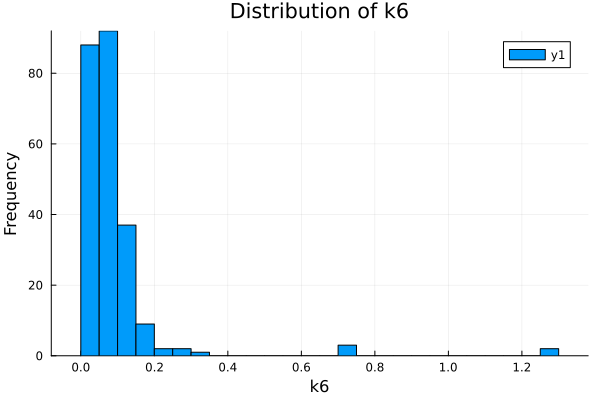

In [112]:
using Statistics
# drop the failed estimations (missing bodyweight)
results = filter(x -> x != nothing, results)

df_k1 = DataFrame(k1 = [results[i][1] for i in 1:length(results)])
df_k5 = DataFrame(k5 = [results[i][2] for i in 1:length(results)])
df_k6 = DataFrame(k6 = [results[i][3] for i in 1:length(results)])

# get statistics of df
# describe(df_k1)

describe(df_k6)

# describe(df_k5)
# create a plot 
using Plots
histogram(df_k5.k5, bins=50, title="Distribution of k6", xlabel="k6", ylabel="Frequency")

In [113]:
using GLMakie

include("./Help functions/PlotAnalysis.jl")

results_df = hcat(df_k1,df_k5, df_k6)

accepted = Interactive_plots_EDES(results_df, glucose_cleaned, insulin_cleaned, bodyweight_cleaned, time_G, time_I, G_dose = G_dose)

236-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [120]:
using CSV


# Filter the results_df dataframe to include only the accepted ones
accepted_df = results_df[accepted .== 1, :]

# Display the accepted dataframe
accepted_df
describe(accepted_df[!,2])
# save the accepted_df to a csv file
CSV.write("./accepted_df_allPERSON.csv", accepted_df)

Summary Stats:
Length:         131
Missing Count:  0
Mean:           0.055734
Std. Deviation: 0.036411
Minimum:        0.003637
1st Quartile:   0.030060
Median:         0.045955
3rd Quartile:   0.075759
Maximum:        0.169576
Type:           Float64


"./accepted_df_allPERSON.csv"

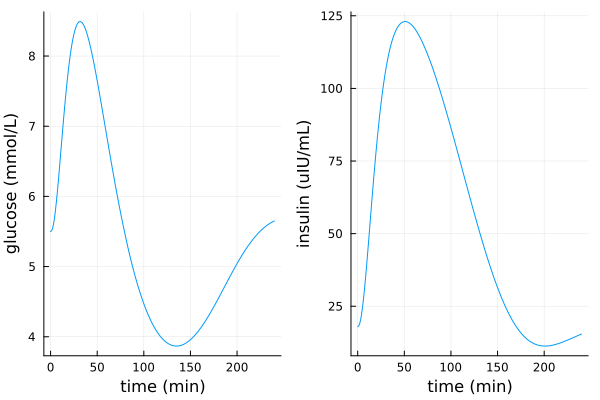

In [121]:
# get parameter values for the accepted patients
accepted_k1 = accepted_df[!, 1]
accepted_k5 = accepted_df[!, 2]
accepted_k6 = accepted_df[!, 3]

# get the mean of the accepted parameters
mean_k1 = mean(accepted_k1)
mean_k5 = mean(accepted_k5)
mean_k6 = mean(accepted_k6)
estimated_parameter_values = [mean_k1, mean_k5, mean_k6]

# simulate someone with the mean parameters
edes_model = EDES()
PlotMealResponse(edes_model,estimated_parameter_values )
# simulate the OGTT
